# Tutorial 2: Fine-tuning Seq2Seq Pre-trained Models for Translation

Welcome to the second tutorial of our class on "Practical Machine Translation for Low Resource Languages". Today, we will be continuing our journey of creating practical translation systems by learning how to fine-tune a pre-trained model for the translation task. We will be considering the [mT5](https://arxiv.org/abs/2010.11934) model by Google and fine-tune it translate English sentences to Hindi. For fine-tuning, we will be using the [IIT Bombay English-Hindi Parallel Corpus](https://www.cfilt.iitb.ac.in/iitb_parallel/).

Pre-requisites for the Tutorial:
- Intermediate Level Python Programming
- Working with Jupyter-Notebooks
- Loading models and tokenizers in 🤗 Transformers



In [1]:
# Installing the necessary packages that we will be using for the tutorial

!pip install torch # Installing Pytorch that we will use as a backend for transformers
!pip install transformers # Installing the transformers library
!pip install datasets # For working with datasets
!pip install sacrebleu # For evaluation of MT models
!pip install evaluate # For evaluation of MT models
!pip install sentencepiece # For tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 80.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 21.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Loading packages that we will be making use of in the tutorial
import io
import json 
import argparse 
import os 
import random
import numpy as np
import datasets 
from datasets import load_dataset, load_metric, load_from_disk
from dataclasses import dataclass, field
import transformers
from transformers import (
    HfArgumentParser, 
    AutoConfig,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    set_seed
)

In [5]:
#Defining data paths please modify accordingly on your machine
DATA_DIR = "/content/drive/MyDrive/IIScTutorials/Tutorial2/data"

## Task 0: Evaluation

The final topic that we will discuss today is evaluating the translation models for the quality of translations produced by them. The idea behind evaluation is to have a numeric score representing how well the model is doing on the task of translation. As for other machine learning problems, to evaluate we use a labelled test dataset containing the original text and the reference translation created by human annotators. The translation produced by the MT system is compared with the reference translation to obtain the score representing the quality of translation. There are a number of different metrics that are used to measure this, some of which we will be discussing in detail in the next lecture. For this tutorial we will be focusing on BLEU score which on a very high level measures the n-gram overlap between the generated and reference translation. A BLEU score of 1 means perfect translation and 0 is the minimum score meaning no n-gram matches between the reference and generation. You can refer to this [article](https://en.wikipedia.org/wiki/BLEU) for more details.
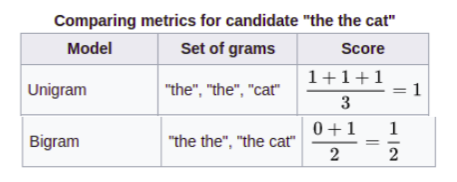

We will first load the test dataset to use for evaluating the quality of translations. We will be using the [FLORES-200](https://github.com/facebookresearch/flores/tree/main/flores200) benchmark, which contains parallel data in 200 languages. The zip file accompanying the tutorial that contains ther data can be uploaded by clicking on Add Data button towards the top-right side of your notebook.


In [6]:
class CustomTranslationPipeline:
    
    def __init__(self, model: str, tokenizer: str):
        """
        Initializes the model and tokenizer for a translation pipeline
        
        Inputs:
            - model (str) : Huggingface model string for the translation model to load
            - tokenizer (str) : Huggingface tokenizer string for the translation model to load.
                                    Often will be same as `model_name`
        """
        
        self.model = None
        self.tokenizer = None
        
        ### BEGIN SOLUTION
        
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model)
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer)
        
    def __call__(self, text: str) -> str:
        """
        Takes in an input text and generates the translation
        
        Inputs:
            - text (str) : Input text to be translated
        
        Returs:
            str: Translated text
        
        Steps to follow:
            - Tokenize the `text` to obtain token ids
            - Feed the ids through the model to obtain output ids
            - Convert output ids to text
        """
        
        ### BEGIN SOLUTION
        
        tokenized_inputs = self.tokenizer(text, return_tensors="pt")
        model_outputs = self.model.generate(input_ids = tokenized_inputs["input_ids"])
        generated_text = self.tokenizer.batch_decode(model_outputs, skip_special_tokens=True)
        
        return generated_text[0]

In [7]:
def read_file(filename):
    with open(filename) as f:
        lines = f.read().split("\n")
    return lines

#Loading English Data
en_data = read_file(f"{DATA_DIR}/flores200_dataset/dev/eng_Latn.dev")

# Loading French Data
fr_data = read_file(f"{DATA_DIR}/flores200_dataset/dev/fra_Latn.dev")

# Display a sample of data
for i in range(5):
    print(f"English: {en_data[i]}")
    print(f"French: {fr_data[i]}")
    print("="*25)

English: On Monday, scientists from the Stanford University School of Medicine announced the invention of a new diagnostic tool that can sort cells by type: a tiny printable chip that can be manufactured using standard inkjet printers for possibly about one U.S. cent each.
French: Des scientifiques de l’école de médecine de l’université de Stanford ont annoncé ce lundi la création d'un nouvel outil de diagnostic, qui permettrait de différencier les cellules en fonction de leur type. Il s'agit d'une petit puce imprimable, qui peut être produite au moyen d'une imprimante à jet d'encre standard, pour un coût d'environ un cent de dollar pièce.
English: Lead researchers say this may bring early detection of cancer, tuberculosis, HIV and malaria to patients in low-income countries, where the survival rates for illnesses such as breast cancer can be half those of richer countries.
French: Selon les chercheurs principaux, cela pourrait permettre une détection précoce du cancer, de la tuberculo


Now that we have loaded the test dataset, we can use it to evaluate the quality of translation of an MT model. We can use the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library for directly evaluating BLEU scores for the generated translations.

In [8]:
# We can load the bleu evaluation instance from the evaluate library
import evaluate
sacrebleu = evaluate.load("sacrebleu")

As an example we will show comparing quality of English -> French translation for the Marian model we saw before

In [9]:
# Initializing our Custom Translation Pipeline
translation_pipeline = CustomTranslationPipeline(
    model="Helsinki-NLP/opus-mt-en-fr",
    tokenizer="Helsinki-NLP/opus-mt-en-fr"
)

# Evaluating on the first example
input_text = en_data[0]
reference_text = fr_data[0]
translated_text = translation_pipeline(input_text)
bleu_score = sacrebleu.compute(predictions = [translated_text], references=  [reference_text])["score"]

print(f"Input: {input_text}")
print(f"Reference: {reference_text}")
print(f"Generation: {translated_text}")
print(f"BLEU Score: {bleu_score}")

/usr/local/lib/python3.8/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Input: On Monday, scientists from the Stanford University School of Medicine announced the invention of a new diagnostic tool that can sort cells by type: a tiny printable chip that can be manufactured using standard inkjet printers for possibly about one U.S. cent each.
Reference: Des scientifiques de l’école de médecine de l’université de Stanford ont annoncé ce lundi la création d'un nouvel outil de diagnostic, qui permettrait de différencier les cellules en fonction de leur type. Il s'agit d'une petit puce imprimable, qui peut être produite au moyen d'une imprimante à jet d'encre standard, pour un coût d'environ un cent de dollar pièce.
Generation: Lundi, des scientifiques de la Stanford University School of Medicine ont annoncé l'invention d'un nouvel outil de diagnostic qui peut trier les cellules par type : une petite puce imprimable qui peut être fabriquée à l'aide d'imprimantes à jet d'encre standard pour environ un cent américain chacune.
BLEU Score: 14.336036318093997


In [10]:
def evaluate_translation_pipeline(
    translation_pipeline,
    input_data,
    reference_data,
):
    """
    Evaluates a translation pipeline using BLEU score
    
    Inputs:
        - translation_pipeline (CustomTranslationPipeline)
        - input_data (List[str]) : A list containing sentences in source language to be translated
        - reference_data (List[str]) : Reference translations of the source langauge data
        
    Returns:
        - float: BLEU score for the translation pipeline on the test data
    """
    
    bleu_score = None
    
    ### BEGIN SOLUTION
    sacrebleu = evaluate.load("sacrebleu")
    translations = []
    for input_text in tqdm(input_data):
        translations.append(
            translation_pipeline(input_text)
        )
    bleu_score = sacrebleu.compute(
        predictions=translations,
        references=reference_data
    )["score"]
    
    return bleu_score

In [ ]:
evaluate_translation_pipeline(
    translation_pipeline,
    en_data,
    fr_data
)

## Homework: Benchmarking MT Models

For this week's home-assignment, we want you to take all that you understood from the tutorial above and use the learnings to evaluate different pre-existing MT models on a language of your choice. Just ensure that the language you select has data in the FLORES-200 benchmark and you can find at least 3 different available models on huggingface for the same. You can find the available translation models [here](https://huggingface.co/models?pipeline_tag=translation&sort=downloads). Also, we expect you to evaluate both models for English -> Language as well as Language -> English. Additionally, if you choose to benchmark for a high-resource language like German, French or Spanish, we would also expect you to evaluate a Prompt-based translation model like FLAN-T5. At the end of the benchmarking excercise you should produce a results table of the following format:

| Model                                      | Translation Direction | Number of Encoder Layers      | Number of Decoder Layers      | BLEU         |
|--------------------------------------------|-----------------------|-------------------------------|-------------------------------|--------------|
| [Some Model_1]                             | En->Lang              | [Value given in model.config] | [Value given in model.config] | [BLEU score] |
| [Similar to Model_1 but reverse direction] | Lang->En              | [Value given in model.config] | [Value given in model.config] | [BLEU score] |
| .                                          | .                     | .                             | .                             | .            |

Based on the results obtained, we want you to answer the following questions:
1. What is the impact of number of encoder and decoder layers on the BLEU scores?
2. Compare the two translation directions En->Lang and Lang->En, are the scores obtained for an equivalent model same for both directions or is one often better than the other?
3. [Optional] You can also experiment with other parameters that might help explain the final performance like number of embeddings, hidden size, number of heads etc. All such information can be found in `model.config`.

## Task 1: Pre-processing the Datasets and Building Dataloaders

In this part we will be first reading the parallel train and test corpora, pre-process it and then create dataloaders to efficiently iterate through the dataset during training and evaluation.

We will read the text files using the `load_dataset` from the [Datasets](https://huggingface.co/docs/datasets/index) library by 🤗. Datasets is a powerful library that makes handling and processing large-scale datasets very convenient. Below we load the English and Hindi text datasets

In [11]:
en_hi_dataset = load_dataset(
    "json",
    data_files = {
        "train": f"{DATA_DIR}/iitb-en-hi/train_sample_en_hi.json",
        "dev": f"{DATA_DIR}/iitb-en-hi/dev_en_hi.json",
        "test": f"{DATA_DIR}/iitb-en-hi/test_en_hi.json"
    },
)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-7cb165ee45838589/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
en_hi_dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'hi'],
        num_rows: 99999
    })
    dev: Dataset({
        features: ['en', 'hi'],
        num_rows: 520
    })
    test: Dataset({
        features: ['en', 'hi'],
        num_rows: 2507
    })
})

A short tutorial on Datasets Library: We can directly index the DatasetDict object created above to obtain a dataset split by it's name. For eg:

In [ ]:
print(f"Train Dataset: {en_hi_dataset['train']}")
print(f"Dev Dataset: {en_hi_dataset['dev']}")
print(f"Test Dataset: {en_hi_dataset['test']}")

Train Dataset: Dataset({
    features: ['en', 'hi'],
    num_rows: 99999
})
Dev Dataset: Dataset({
    features: ['en', 'hi'],
    num_rows: 520
})
Test Dataset: Dataset({
    features: ['en', 'hi'],
    num_rows: 2507
})


`num_rows` show the number of examples present for a selected dataset split. A particular example at an index `i` can be accessed directly by indexing:

In [ ]:
print(f"Train Dataset: {en_hi_dataset['train'][0]}")

Train Dataset: {'en': 'The wealth of the castle was stored in the form of bars of silver.', 'hi': 'किले की समृद्धि चांदी की ईंटों के रूप में भंडारित करके रखी गयी थी। '}


Now that our dataset is loaded, we will process the same to be usable by the model. As explained in the last tutorial, we will be using a tokenizer to convert both English and Hindi sentences to a sequence of token ids.

We start by loading the tokenizer for the model that we want to fine-tune i.e. `mt5-small`

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")

/usr/local/lib/python3.8/dist-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Revisiting output of a tokenizer object

In [ ]:
example_text = "Fine-tuning machine translation models is fun!"
tokenizer(example_text)

{'input_ids': [38820, 264, 110160, 10902, 53802, 33477, 339, 2925, 309, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

As discussed in the previous class the tokenizer returns a list of token ids represented here by `input_ids`. It also returns something called an `attention_mask` which we briefly alluded to in the previous tutorial. The purpose of an `attention_mask` is to specify what tokens to avoid attending to while computing the hidden representations. These tokens to be avoided are generally Padding tokens which are appended to the inputs to ensure that all sequences are of the same sequence length. In this particular example `attention_mask` is simply a vector of all 1's, simply meaning that there is no such padding token in the processed input. By providing a value to `max_length` while calling the tokenizer and setting padding = "max_length", will pad the input to the specified length.

In [ ]:
tokenizer(example_text, padding = "max_length", max_length = 128)

{'input_ids': [38820, 264, 110160, 10902, 53802, 33477, 339, 2925, 309, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

As can be seen some the `input_ids` are now appended with token ids 0 which in the case of mt5 refer to the padding tokens. Similarly `attention_mask` has now a sequence of 0s to identify the padding tokens.

In [ ]:
tokenizer(example_text, max_length = 48, padding = True, truncation = True)

{'input_ids': [38820, 264, 110160, 10902, 53802, 33477, 339, 2925, 309, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

We will now implement a function that takes in a dataset example and tokenizes both the english and hindi text to obtain model inputs as well as expected output. Since, we are building a translation system from English -> Hindi, for the model inputs we will consider english text and hindi text for the labels.

In [ ]:
def process_example(
    example,
    tokenizer,
    src_lang = "en",
    tgt_lang = "hi",
    max_length = 48,
    prefix = ""
  ):

  """
  Takes in a dataset `example` and tokenizes both the english and hindi texts to
  obtain model inputs as well as expected output.

  Inputs:
    - example (dict) : A dictionary with keys "en" for English text and "hi" for
    hindi text
    - tokenizer (PreTrainedTokenizer) : The tokenizer to use to process input
    and output texts
    - src_lang (str) : Language text to use for input
    - tgt_lang (str) : Language to translate to and hence use as output
    - prefix (str) : Prefix to prepend to the input text
  
  Returns:
    - (dict) : Dictionary containing `input_ids`, `attention_mask` and `labels`
  """

  # Step 1: Tokenize source langauge text to be used as inputs
  input_text = prefix + " " + example[src_lang]
  model_inputs = None
  ### BEGIN SOLUTION
  model_inputs = tokenizer(input_text, max_length = max_length,  padding = True, truncation = True)
  ### END SOLUTION

  input_ids = model_inputs["input_ids"]
  attention_mask = model_inputs["attention_mask"]

  # Step 2: Tokenize target language text
  output_text = example[tgt_lang]
  ### BEGIN SOLUTION
  model_outputs = tokenizer(output_text, max_length = max_length,  padding = True, truncation = True)
  ### END SOLUTION

  output_ids = model_outputs["input_ids"]

  return {
      "input_ids" : input_ids,
      "attention_mask" : attention_mask,
      "labels" : output_ids
  }

Lets test the function on an example

In [ ]:
example = en_hi_dataset['train'][0]
process_example(example, tokenizer)

{'input_ids': [486,
  259,
  91250,
  304,
  287,
  259,
  108708,
  639,
  5317,
  285,
  281,
  287,
  2885,
  304,
  68751,
  304,
  33043,
  260,
  1],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [1676,
  1048,
  975,
  3526,
  127776,
  3081,
  28523,
  113006,
  975,
  259,
  1665,
  25324,
  1396,
  641,
  259,
  9293,
  844,
  2573,
  83764,
  76735,
  1100,
  2916,
  259,
  17928,
  1304,
  1462,
  17149,
  259,
  8798,
  378,
  259,
  1]}

We can now apply this function to all examples in our datasets. The Datasets library provides `map` function that makes parallel processing of dataset examples extremely convenient.

In [ ]:
train_dataset = en_hi_dataset["train"]
train_dataset = train_dataset.map(
    lambda example: process_example(example, tokenizer,
                                    prefix = "translate English to Hindi",
                                    max_length = 48),
    num_proc = 8, # For parallelization
    remove_columns = ["en", "hi"]
)


dev_dataset = en_hi_dataset["dev"]
dev_dataset = dev_dataset.map(
    lambda example: process_example(example, tokenizer, 
                                    prefix = "translate English to Hindi",
                                    max_length = 48),
    num_proc = 8, # For parallelization
    remove_columns = ["en", "hi"]
)

test_dataset = en_hi_dataset["test"]
test_dataset = test_dataset.map(
    lambda example: process_example(example, tokenizer,
                                    prefix = "translate English to Hindi",
                                    max_length = 48),
    num_proc = 8, # For parallelization
    remove_columns = ["en", "hi"]
)

Map (num_proc=8):   0%|          | 0/99999 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/520 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/2507 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['en', 'hi', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 99999
})

The final component required for dataset processing is initializing a Data Collator. The purpose of a collator is take sequence of examples and form batches out of them. Training the model with batched inputs is much more compute efficient as well as results in a better approximation of the gradient compared to using a single example. For translation task, we can use the `DataCollatorForSeq2Seq` class from the transformers library to initialize the collator.

In [ ]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer)

## T2: Fine-tuning mT5 using Trainer





Let's revisit the concept of working with models; We briefly discussed using models that are available in the marketplace (remember "MarianMT" models?) As you can imagine, these are models that already have a meaningful idea about the task they are being asked to (in this case translation). This is because they have been consciously trained for translation before. Such models, which have already been trained for a given task (or a collection of tasks) are called **Pre-Trained Models** .

Pre-trained models are very beneficial because they (a) can be rapidly adapt given tasks on your data (b) without incurring a significant time and computation cost. 


What you'll see in the next steps is a powerful pretrained learner called **mt5 or the multilingual T5**. This model has seen data from 108 languages and being an encoder-decoder model, can develop very powerful contextual representations in these langauges, _even the unseen ones_.


In [ ]:
from transformers import AutoModelForSeq2SeqLM
model = AutoModelForSeq2SeqLM.from_pretrained("google/mt5-small")

Now that you have a powerful initial model and a good dataset - you need to have some way of evaluating it so that (a) during training: you can enforce the model to modify itself the best possible manner for translation on your dataset and (b) during evaluation: understand how it performs on unseen set of samples. For both of these purposes, we can use the evaluation process that we began this class with. 

In [ ]:
# First we load BLEU, our primary metric, from a suite of metrics called sacrebleu. 

metric = load_metric("sacrebleu")

def postprocess_text(preds, labels):
        '''
        A helper function which strips trailing spaces at the end of our predictions and sequences. 
        '''
        preds = [pred.strip() for pred in preds]
        labels = [[label.strip()] for label in labels]
        return preds, labels

def compute_metrics(eval_preds):
    '''
    A function that computes the BLEU, given the predictions of the model. 
    BLEU's computation requires us to pass the gold labels and the model' predictions. 
    '''
    # Step 1: We catch our model' predictions and use our precomputed, encoded labels to start the comparison process. 
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    
    # Step 2: Then we decode them 
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    # Step 3: Finally, we pass them to BLEU
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    output_prediction_file = os.path.join(training_args.output_dir, f'{result["score"]}_generated_predictions.txt')

    # Step 4: Here we write the prediction file so that we can observe the evolution of the model' generation. 
    with open(output_prediction_file, "w", encoding="utf-8") as writer:
            writer.write("\n".join(decoded_preds))
            result = {"bleu": result["score"]}
    return result

<ipython-input-19-45865bf5335f>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("sacrebleu")


## Training the Model

Now that we have all the pillars (data, model and evaluation pipeline) - We can start training our model. As before, we will start with an abstracted pipeline that will train the model for us. Let's look at some of the parameters that we will use here. 

In [ ]:
training_args = Seq2SeqTrainingArguments('./')

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
training_args

Seq2SeqTrainingArguments(output_dir='./', overwrite_output_dir=False, do_train=False, do_eval=False, do_predict=False, evaluation_strategy=<IntervalStrategy.NO: 'no'>, prediction_loss_only=False, per_device_train_batch_size=8, per_device_eval_batch_size=8, per_gpu_train_batch_size=None, per_gpu_eval_batch_size=None, gradient_accumulation_steps=1, eval_accumulation_steps=None, eval_delay=0, learning_rate=5e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=3.0, max_steps=-1, lr_scheduler_type=<SchedulerType.LINEAR: 'linear'>, warmup_ratio=0.0, warmup_steps=0, log_level='passive', log_level_replica='passive', log_on_each_node=True, logging_dir='./runs/Mar02_18-53-07_74484770561d', logging_strategy=<IntervalStrategy.STEPS: 'steps'>, logging_first_step=False, logging_steps=500, logging_nan_inf_filter=True, save_strategy=<IntervalStrategy.STEPS: 'steps'>, save_steps=500, save_total_limit=None, save_on_each_node=False, no_cuda=Fal

### Learning Parameters 
1. Learning Rate
2. Gradient Accumulation Steps 
3. Batch Size 
4. Evaluation Accumulation Steps 
5. Number of Epochs 
6. Save Total Limit 

In [ ]:
save_dir = "/content/drive/MyDrive/IIScTutorials/Tutorial2/models/mt5_small_en_hi/"
training_args = Seq2SeqTrainingArguments(
    output_dir = save_dir,
    learning_rate = 1e-3, 
    gradient_accumulation_steps = 2, 
    per_device_train_batch_size = 8, 
    per_device_eval_batch_size=16,
    do_train = True, 
    do_eval = True, 
    do_predict = False, 
    num_train_epochs = 10,
    fp16 = False, 
    eval_accumulation_steps=2, 
    log_on_each_node=False, 
    eval_steps = 1000,
    predict_with_generate = True, 
    evaluation_strategy = 'steps',
    save_total_limit=1,
    save_steps=1000,
    save_strategy="steps"
    )

In [ ]:
# Fixing Seed for reproducibility - This can be considered as an anchor that makes sure that the model's modification are bounded against a range. 
set_seed(42)

# Now we initialize the object that is responsible for handling our training
trainer = Seq2SeqTrainer(
    model=model, 
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [ ]:
train_result = trainer.train()

The following columns in the training set don't have a corresponding argument in `MT5ForConditionalGeneration.forward` and have been ignored: hi, en. If hi, en are not expected by `MT5ForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 99999
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 2
  Total optimization steps = 62500
  Number of trainable parameters = 300176768
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a metho

Step,Training Loss,Validation Loss


The following columns in the evaluation set don't have a corresponding argument in `MT5ForConditionalGeneration.forward` and have been ignored: hi, en. If hi, en are not expected by `MT5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 520
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



KeyboardInterrupt: ignored

Now that the model is trained, we can load it (not needed if the runtime wasn't disconnected) and qualitatively examine its outputs

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/IIScTutorials/Tutorial2/models/mt5_small_en_hi/")
tokenizer = AutoModelForSeq2SeqLM.from_pretrained("google/mt5-small")

input_text = "learning is fun"
prompt = f"translate English to Hindi {input_text}"
tokenized_prompt = tokenizer(prompt, return_tensors="pt")
model_output = model.generate(input_ids = tokenized_prompt["input_ids"])
generation_text = tokenizer.batch_decode(model_output)
print(generation_text)

## T3: Diving Deep into The Trainer: Writing our own training loop

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

In [ ]:
class CustomSeq2SeqTrainer:

  def __init__(
      self,
      train_dataset,
      eval_dataset,
      model,
      tokenizer,
      data_collator,
      compute_metrics_fn,
      eval_metric="bleu",
      device="cuda",
      output_dir="checkpoints/",
      batch_size=8,
      learning_rate=1e-3,
      num_train_epochs=10
  ):

    self.train_dataset = train_dataset
    self.eval_dataset = eval_dataset
    self.model = model
    self.device = device
    self.tokenizer = tokenizer
    self.data_collator = data_collator
    self.compute_metrics_fn = compute_metrics_fn
    self.eval_metric = eval_metric

    # Put the model to device
    self.model.to(device)

    # Create Dataloaders
    self.train_loader = DataLoader(train_dataset, 
                                   batch_size = batch_size,
                                   collate_fn=self.data_collator)
    self.eval_loader = DataLoader(eval_dataset, 
                                  batch_size = batch_size,
                                  collate_fn=self.data_collator)
    
    # Initialize the Optimizer
    self.optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Initialize train arguments
    self.output_dir = output_dir
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.num_train_epochs = num_train_epochs

  def send_batch_to_device(self, batch):
    return {k : v.to(self.device) for k,v in batch.items()}

  def save_pretrained(self):
    self.model.save_pretrained(self.output_dir)

  def eval_step(self, batch):
    
    # Get model predictions
    with torch.no_grad():
      preds = self.model.generate(
          input_ids=batch["input_ids"],
          attention_mask=batch["attention_mask"]
      )
      preds = preds.detach().cpu().numpy()

    # Call compute metrics
    eval_results = self.compute_metrics_fn((preds, batch["labels"].cpu().numpy()))

    return eval_results[self.eval_metric]

  
  def eval(self):
    eval_score = 0
    for batch in tqdm(self.eval_loader):
      batch = self.send_batch_to_device(batch)
      eval_score += self.eval_step(batch)
    
    eval_score = eval_score / len(self.eval_loader)
    return eval_score


  def train_step(self, batch):

    # Zero out any existing computed gradients
    self.optimizer.zero_grad()

    # Perform forward pass through the model
    model_output = self.model(**batch)
    loss = model_output.loss # Since the batch in our case contains labels too, the forward pass will compute the loss as well

    # Compute gradients
    loss.backward()

    # Update the model parameters using optimizer
    self.optimizer.step()

    return loss.item()

  def train(self):

    for epoch in tqdm(range(self.num_train_epochs)):
      train_loss_epoch = 0
      for batch in tqdm(self.train_loader):
        # Copy the batch to the specified device (cuda or cpu)
        batch = self.send_batch_to_device(batch)

        # Do one train step
        train_loss_epoch += self.train_step(batch)
      
      train_loss_epoch /= len(self.train_loader)
      print("Evaluating...")
      eval_score = self.eval()

      print(f"Epoch {epoch+1} completed.")
      print(f"Train loss: {train_loss_epoch}")
      print(f"Eval {self.eval_metric}: {eval_score}")

      self.save_pretrained()

In [ ]:
train_dataset_small = train_dataset.select(range(1000))
trainer = CustomSeq2SeqTrainer(
      train_dataset_small,
      dev_dataset,
      model,
      tokenizer,
      data_collator,
      compute_metrics_fn = compute_metrics,
      eval_metric="bleu",
      device="cuda",
      output_dir="checkpoints/",
      batch_size=8,
      learning_rate=1e-3,
      num_train_epochs=3
)

In [ ]:
trainer.train()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 1 completed.
Train loss: 1.0334154343605042
Eval bleu: 0.9938829542698834


  0%|          | 0/125 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 2 completed.
Train loss: 0.6817140748500824
Eval bleu: 1.0878972086400172


  0%|          | 0/125 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 3 completed.
Train loss: 0.4705064826011658
Eval bleu: 1.0177668428377684


In [ ]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()